In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
os.chdir('/content/drive/My Drive/IR')

import required libraries


In [0]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import copy
import pickle

# Data Cleaning and Pre-processing

Install 7zip implementation for python using pip package maanger.

unzip the two files in same folder.

In [0]:
os.listdir()
!pip install py7zr
!py7zr x 'color.7z' '.'
!py7zr x 'objects_sub.7z' '.' 

     |████████████████████████████████| 61kB 1.1MB/s 
     |████████████████████████████████| 13.7MB 1.6MB/s 
not a 7z file
not a 7z file


Helper Functions

In [0]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

Assigning paths of dataset, batch size and number of epochs

In [0]:
class Config():
    training_dir = "./data/objects_sub/training/"
    testing_dir = "./data/objects_sub/testing/"
    train_batch_size = 64
    train_number_epochs = 10

This is a custom dataset class.

It'll generate pair of images as input for siamese network.

Returns 2 images and and a number (0 for same class and 1 for different class).

In [0]:
class SiameseNetworkDataset(Dataset):  
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found
                
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

Making dataset using *torchvision.datasets*

In [0]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)

In [0]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

The top row and the bottom row of any column is one pair. The 0s and 1s correspond to the column of the image. 1 indiciates dissimilar, and 0 indicates similar.

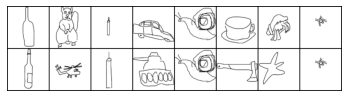

[[0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]]


In [0]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

# Neural Network Construction

Neural Network Definition.

Implements standard ConvNet outputing a feature vector.

In [0]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

*Contrastive* Loss Function.

*Dimensionality Reduction by Learning an Invariant Mapping. R, Hadsell et al. CVPR 2006*

In [0]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

# Training

In [0]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

In [0]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 ) #learning rate = 0.0005

In [0]:
counter = []
loss_history = [] 
iteration_number= 0

In [0]:
for epoch in range(0,Config.train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
show_plot(counter,loss_history)

Testing

Dissimilarity score tells how dissimilar the two images are.

Higher is the score, higher will be the dissimilarity and vice-versa. 

In [0]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)

for i in range(10):
    _,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))

Save model alongwith weights for later use.

In [0]:
PATH = 'siamese_network'
torch.save(net, PATH)

# Image Retrieval from Sketch

Load saved model and push it to default GPU device

In [0]:
PATH = 'siamese_network'
model = torch.load(PATH)
model.eval()
model.cuda()

SiameseNetwork(
  (cnn1): Sequential(
    (0): ReflectionPad2d((1, 1, 1, 1))
    (1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
    (2): ReLU(inplace=True)
    (3): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReflectionPad2d((1, 1, 1, 1))
    (5): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU(inplace=True)
    (7): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReflectionPad2d((1, 1, 1, 1))
    (9): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (10): ReLU(inplace=True)
    (11): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc1): Sequential(
    (0): Linear(in_features=80000, out_features=500, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=500, out_features=5, bias=True)
  )
)

Define Transformations

In [0]:
transformation=transforms.Compose([transforms.Resize((100,100)),
                                  transforms.ToTensor()])



---
Ignore !!


In [0]:
image1 = Image.open('owl.png')
image1 = image1.convert('L')
image2 = Image.open('shark_1.png')
image2 = image2.convert('L')

In [0]:

image1_tensor = transformation(image1)

image1_tensor = image1_tensor.unsqueeze_(0)
image2_tensor = transformation(image2)
image2_tensor = image2_tensor.unsqueeze_(0)

In [0]:
input1 = Variable(image1_tensor)
input2 = Variable(image2_tensor)



In [0]:
s1, s2 = model(input1.cuda(), input2.cuda()) #needs two images

In [0]:
euclidean_distance = F.pairwise_distance(s1, s2)


In [0]:
euclidean_distance.item()

0.6369343400001526

In [0]:
s1

tensor([[ 1.1719, -1.1315, -0.7681,  0.8947, -0.0464]], device='cuda:0',
       grad_fn=<AddmmBackward>)

In [0]:
s1_new

tensor([[ 1.1719, -1.1315, -0.7681,  0.8947, -0.0464]], device='cuda:0',
       grad_fn=<AddmmBackward>)



---



Load Database

In [0]:
training_dir = "./data/objects_sub/training/"
classes_list = os.listdir(training_dir)

In [0]:
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [0]:
image_scores = load_obj("Image_scores")




--- 
Ignore !!



Save feature vector of every image in image_scores dictionary where key corresponds to image file's name. 

In [0]:
#already implemented and output stored as file
for folder in classes_list:
    images_path = training_dir + '/' + folder
    images_name = os.listdir(images_path)
    img1, img2 = Image.open(images_path + '/' + images_name[0]), Image.open(images_path + '/' + images_name[1])
    image1, image2 = img1.convert('L'), img2.convert('L')
    image1_tensor, image2_tensor = transformation(image1), transformation(image2)
    image1_tensor, image2_tensor = image1_tensor.unsqueeze_(0), image2_tensor.unsqueeze_(0)
    input1, input2 = Variable(image1_tensor), Variable(image2_tensor) 
    s1, s2 = model(input1.cuda(), input2.cuda())
    # s1[0] = [(a+b)/2 for a,b in zip(s1, s2)]
    image_scores[folder] = s1 

    # image_scores[folder], _ = model(input1.cuda(), input1.cuda())
    # print(images_name[0], folder, image_scores[folder])
    # for i in range(1, len(images_name)-1):
    #     image1, image2 = Image.open(images_path + '/' + images_name[i]), Image.open(images_path + '/' + images_name[i+1])
    #     image1, image2 = img1.convert('L'), img2.convert('L')
    #     image1_tensor = transformation(image1)
    #     image1_tensor = image1_tensor.unsqueeze_(0)
    #     image2_tensor = transformation(image2)
    #     image2_tensor = image2_tensor.unsqueeze_(0)
    #     input1 = Variable(image1_tensor)
    #     input2 = Variable(image2_tensor)
    #     s1, s2 = model(input1.cuda(), input2.cuda())
    #     score = [[a+b for a,b in zip(s1[0], score[0])]]
    #     score = [[a+b for a,b in zip(s2[0], score[0])]]

In [0]:
# save the scores which has been done, executed only once
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [0]:
# executed once only
save_obj(image_scores, "Image_scores")



---



Function which returns 20 images found to be most similar to input image by the network.

In [0]:
def find_results(image_path):
  img = Image.open(image_path)
  img = img.convert('L')
  image_tensor = transformation(img)
  image_tensor = image_tensor.unsqueeze_(0)
  input1 = Variable(image_tensor)
  s1, _ = model(input1.cuda(), input1.cuda())
  distance = dict()
  for image, score in image_scores.items(): 
    distance[image] = F.pairwise_distance(s1, score).item()
  ans = sorted(distance.keys(), key = lambda x : distance[x])
  return ans, distance

In [0]:
ans, distance = find_results('bottle.png')

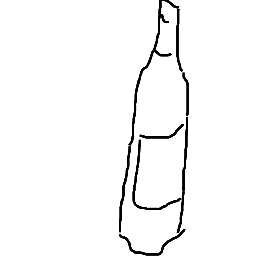

In [0]:
bottle = Image.open('bottle.png')
bottle

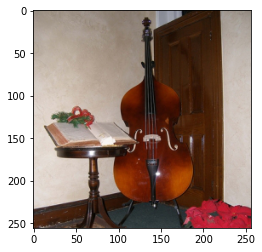

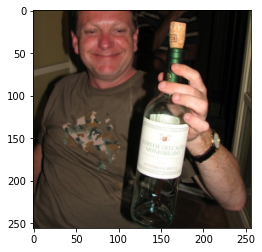

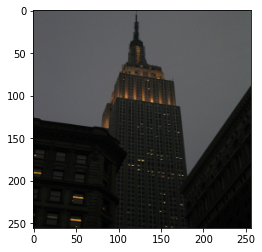

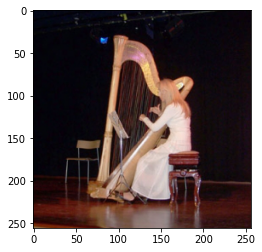

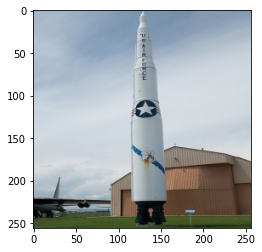

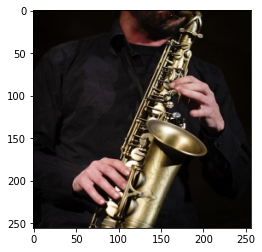

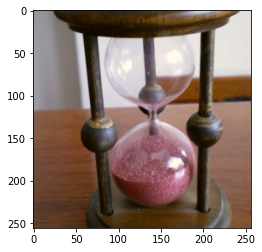

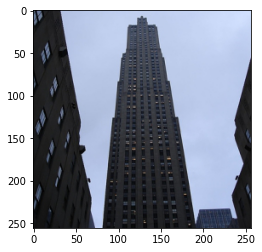

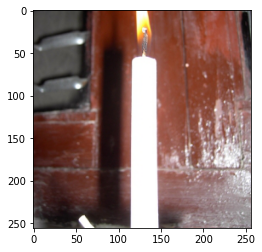

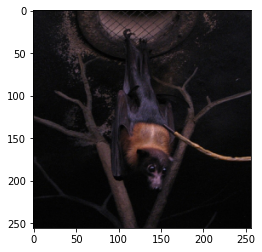

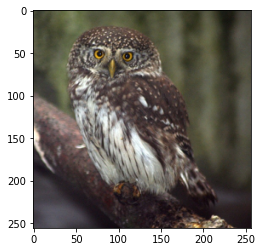

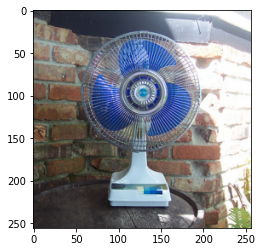

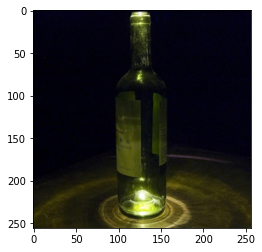

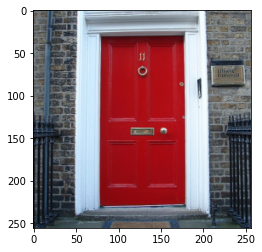

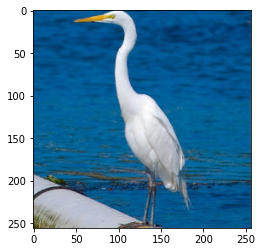

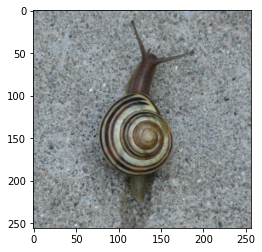

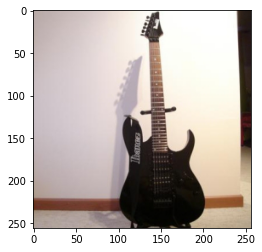

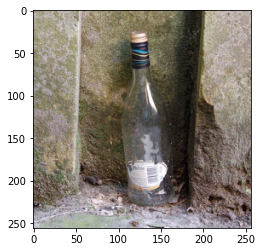

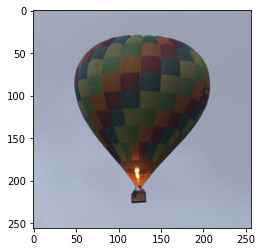

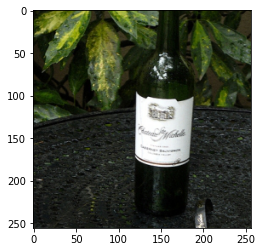

In [0]:
for i in range(20):
  res = Image.open('color//'+ans[i]+'.jpg')
  plt.figure()
  plt.imshow(res)
  plt.show()

  # arr.append(col_image)
  # # print(ans[i], distance[ans[i]])